# CSCI2000U - Final Project


## Introduction

We chose this dataset pulled off of Kaggle because it pertains to movies and tv series, which everyone in the group is familiar with, and also has an interest in. Going through other datasets, we were often disappointed either by the lack of data, or the range of categories that are covered within the dataset. This dataset was able to do what we needed: have lots of data we can parse, and have lots of columns we can work with.

We initially looked at using sets such a Utility Cut permits or chemical tracking data for the city of Toronto, but they either didn't have enough data to reasonably work with or weren't interesting to everyone in the group.

Due to this, we decided to go with the IMDB's most popular films and series set.



### These are the list of questions we wish to answer, and expand upon in our analysis:
   - How does the amount of episodes in a tv show effect the ratings? For shows with a greater amount of episodes,
        are the average rating worse, or better than shows with fewer?
   - What are considered popular genres over the years? Do the ratings correlate? 
   - What impact does mature content make on the ratings of movies/shows the most?
   - Do TV series or movies perform better? Based on the year of publish, does this make an impact or change the ratings?

### Members and contributions:

Ashar Izhar ->

Bridget Green ->

Cameron Millar ->

Julian Finley -> 


## Description of Data

The IMDB's most popular film and series dataset is a list described by its name. In this dataset we can see a range of movies and films from the early 20th century to the current year, with information about the movie such as duration, genre, number of episodes, as well as user engagement information such as ratings and votes. All these datapoints can prove to be useful when diving into the analysis of said data.

The data was collected by the dataset creator using web scraping directly from the IMDB website, and then compiled within a csv file for ease of use.

Full credits go towards the compiler of the dataset; Mazen Ramadan, with a link to the set itself: https://www.kaggle.com/mazenramadan/imdb-most-popular-films-and-series

Information from this dataset was retrieved from the original source: https://www.imdb.com/


## Analysis of the data

The data is organized in such a manner thatis easy to identify their use case and how they can be manipulated. Below is the list of columns within the dataset, and their description:

    Name: The title of the film or tv series
    Date: The date by year
    Rate: The IMDB rating given for the title
    Votes: The number of user votes which have contributed the the votes column
    Genre: The genre(s) of the film or tv series. Multiple can be listed per title
    Duration: The running length in minutes for the film or tv series per episode.
    Type: The indicator on whether this is a film or tv series
    Certificate: The audiance and/or age rating for the title(TV-Y, PG, PG-13, etc)
    Episodes: If this is a tv series, the number of episodes present is recorded
    Adult oriented content present(from mild, moderate, severe):
        -Nudity
        -Violence
        -Profanity
        -Alcohol
        -Frightening
      
The data quality holds up, and any missing data present is due to it either being non-existant(i.e., no adult content being in an all ages movie), or no votes/ratings(no user engagement with the film or tv series).

Data that would be prudent to double check for integrity and cleaning would be:
    
    -Completely empty columns
    -Missing or non-numerical dates
    -Removal of 'No Rates' when doing analysis on the ratings column 
    -Removal of 'No Votes' when doing analysis on the votes column
    -If the genre column has more than one genre, make sure all are taken into account for their appropriate use cases.
    -Removal of 'None' when doing analysis on the duration column
    -When doing analysis on the type column, specify directly which will be worked with
    -Remove all non-numerical from episode column if working with tv series
    -When working will adult content, remove 'No Rate' entries

## Exploratory Data Analysis

In [23]:
#Given a csv file format, we must make it usable by pandas in order to make it a dataframe

import csv
import re
from functools import reduce
import numpy as np
import pandas as pd
import json
pd.options.mode.chained_assignment = None  # default='warn'

import calendar
import string
import matplotlib.pyplot as plt
import sys
!{sys.executable} -m pip install seaborn
import seaborn as sns


def get_data_csv():
    collection = []
    with open('imdb.csv', 'r') as f:
        for line in csv.DictReader(f):
            collection.append(line)
        return collection
        
# the data    
data = get_data_csv()
df = pd.DataFrame(data)

     |████████████████████████████████| 292 kB 2.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


### Basic Analysis of the data

In [2]:
#Date Range
maxYear = max(data, key=lambda item:item['Date'])
minYear = min(data, key=lambda item:item['Date'])
print ("Range in years:", (minYear['Date']), "-", (maxYear['Date']))

#Number of records
print("# of data records:", len (data))

#Unique genres by length
uniqueGenres = set(item['Genre'] for item in data)
print("# of unique genres: ", len(uniqueGenres))

#Unique titles by type
uniqueFilms = list(filter(lambda item: 'Film' in item['Type'], data))
uniqueSeries = list(filter(lambda item: 'Series' in item['Type'], data))
print("# of unique movies: ", len(uniqueFilms))
print("# of unique shows: ", len(uniqueSeries))

#Unique ratings by length
uniqueRatings = set(item['Rate'] for item in data)
print("# of unique ratings: ", len(uniqueRatings))

#Top 3 records
print("Top 3 records:", json.dumps(data[:3],indent=4),'\n')

Range in years: 1922 - 2023
# of data records: 6178
# of unique genres:  377
# of unique movies:  4446
# of unique shows:  1732
# of unique ratings:  77
Top 3 records: [
    {
        "Name": "No Time to Die",
        "Date": "2021",
        "Rate": "7.6",
        "Votes": "107,163",
        "Genre": "Action, Adventure, Thriller",
        "Duration": "163 ",
        "Type": "Film",
        "Certificate": "PG-13",
        "Episodes": "-",
        "Nudity": "Mild",
        "Violence": "Moderate",
        "Profanity": "Mild",
        "Alcohol": "Mild",
        "Frightening": "Moderate"
    },
    {
        "Name": "The Guilty",
        "Date": "2021",
        "Rate": "6.3",
        "Votes": "64,375",
        "Genre": "Crime, Drama, Thriller",
        "Duration": "90 ",
        "Type": "Film",
        "Certificate": "R",
        "Episodes": "-",
        "Nudity": "None",
        "Violence": "None",
        "Profanity": "Severe",
        "Alcohol": "None",
        "Frightening": "Moderate"


This summary of data just give us a small bit of understanding about what to expect when working with the data, and the details of the certain ranges and parameters to help in future analysis calculations.

We see that the range of films is from the early 20th century to a couple years into the future; which means there are surely some currently unwatchable programs on the list.
Additionally as a movie database, it makes sense that there are more films present than tv series, at nearly double the count.

### Answering our questions about the dataset

#### How does the amount of episodes in a tv show effect the ratings? For shows with a greater amount of episodes, are the average rating worse, or better than shows with fewer?

In [8]:
#First we drop the duplicates in the dataframe. After analysis, it was discovered there was over 1000 duplicate entries
#in the dataset, which could have surely skewed results.
df = df.drop_duplicates()

#Since we are looking at the 'Rate' and 'Type' column specifically for this question, we should clean the column of 
#missing ratings, and then isolute for 'Series' only
newDfSeries = df[df['Rate'] != 'No Rate']
newDfSeries = newDfSeries.loc[newDfSeries['Type'] == 'Series']

#For displaying various charts, it's a good idea to set the types of the entries to something readable by pd plot
newDfSeries['Episodes'] = newDfSeries['Episodes'].astype(int)
newDfSeries['Rate'] = newDfSeries['Rate'].astype(float)
newDfSeries['Date'] = newDfSeries['Date'].astype(int)

#Lastly sort by episode count, since this is the most important metric for analysis
newDfSeries = newDfSeries.sort_values(by=['Episodes'], ascending=False)
newDfSeries

,Name,Date,Rate,Votes,Genre,Duration,Type,Certificate,Episodes,Nudity,Violence,Profanity,Alcohol,Frightening
2075,Days of Our Lives,2021,5.1,"6,506","Drama, Romance",60,Series,TV-14,14301,Moderate,Mild,Mild,Moderate,Mild
2514,The Young and the Restless,2021,5.1,"5,978","Drama, Romance",60,Series,TV-14,12277,Moderate,Severe,Severe,Mild,Mild
2807,Coronation Street,2020,5.6,"5,202","Drama, Romance",30,Series,TV-PG,10336,Mild,Moderate,Mild,Mild,Mild
4257,Neighbours,2014,5.4,"5,020","Drama, Romance",22,Series,TV-G,9059,Mild,Mild,Mild,Mild,Mild
2951,The Bold and the Beautiful,2015,3.4,"7,411","Drama, Romance",30,Series,TV-14,8365,Mild,Mild,Mild,Mild,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2789,Crime Stories: India Detectives,2021,7.4,646,"Documentary, Crime, Mystery",47,Series,TV-MA,4,No Rate,No Rate,No Rate,No Rate,No Rate
2555,LuLaRich,1956,7.8,"2,381",Documentary,None,Series,TV-14,4,No Rate,No Rate,No Rate,No Rate,No Rate
1552,Time,1990,8.3,"14,288","Crime, Drama",59,Series,None,3,No Rate,No Rate,No Rate,No Rate,No Rate
2120,The Problem with Jon Stewart,2014,7.6,443,Talk-Show,None,Series,TV-MA,3,None,Moderate,Severe,None,Severe


We can see from the head and tail of this dataframe, that the highest amount of episodes is well into the high thousands, and then have a low of 3 to 4 episodes. Just using basic reasoning we can assume the top bulk of shows will be low budget, long running series... while the bottom bulk will likely have been one-offs, or cancelled early into airing.

In [19]:
#In search of just some raw data analysis, we can find the average score of the top and bottom percentage groups. 
#In this case, we will take the top and bottom 20%, and see how the averages differ.
perc = 20
print("Amount of records in each of the top & bottom ", perc, "%: ", int(len(newDfSeries)*(perc/100)),  sep='')

#We are able to calculate the top and bottom percentage average by taking the length of the series dataframe
topPerc = newDfSeries.head(int(len(newDfSeries)*(perc/100)))
botPerc = newDfSeries.tail(int(len(newDfSeries)*(perc/100)))
print("Top ", perc, "%: ", topPerc['Rate'].astype(float).mean(), sep='')
print("Bottom ", perc, "%: ", botPerc['Rate'].astype(float).mean(), sep='')
print("Overall average rating: ", newDfSeries['Rate'].mean())

Amount of records in each of the top & bottom 20%: 282
Top 20%: 7.461347517730496
Bottom 20%: 7.104255319148937
Overall average rating:  7.549148936170212


We can see that the top 20% of series by episode count actually have an on-average higher rating than the bottom 20%. This is an interesting result, and count be for various reasons. To speculate, series that go for a long time usually only do so when proped up by fans and success factors, which would result in a higher score. On the other end, if a series is not successful or popular, it is likely to have fewer good ratings, and be cancelled early in its run.

While these speculations make sense, they do not necessarily mean they're true, and they certain do not line up with the top and bottom 5 entries... though those could also be an anomoly as well.

However, we can also see that the top and bottom 20% are outliers in their own right... as the overall average for all series is greater than both. 

<AxesSubplot:xlabel='Episodes', ylabel='Ratings'>

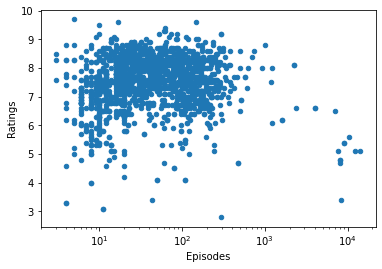

In [5]:
#Lets graph the results of the dataframe.
newDfSeries.plot(xlabel='Episodes', ylabel='Ratings', x='Episodes',y='Rate', kind='scatter', logx=True)

Since there are a lot of records, a scatter graph felt appropriate for this question. We can see that a vast majority of series have rating ranging from ~6.5 to ~8.5, which places the afformentioned overall average directly in the centre of this observation. While there are plenty of dots outside the cluster, the graph still may be hard to parse, due to the extreme amounts of episodes some series may have.

<AxesSubplot:xlabel='Episodes', ylabel='Ratings'>

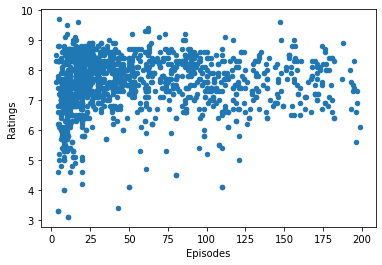

In [6]:
#To the above point, it may be appropriate to see how the average series compares to one another. Due to most series having
#an upper limit of around 200 episodes(10 seasons * 20 episodes per season), we can see how the graph looks like with these
#new limitations
newDfSeries2 = newDfSeries[~(newDfSeries['Episodes'] >= 200)]
newDfSeries2.plot(xlabel='Episodes', ylabel='Ratings', x='Episodes', y='Rate', kind='scatter')

With an upper bound defined, the distribution is much easier to identify. A lot of series are still clustered together, but we can clearly see a downwards trend of ratings and the episode count gets greater and greater for the series. The slope is fairly minor, but noticable.

To answer the question: The amount of total episodes does infact appear to affect the ratings in the long run. Once a show is able to establish itself after about 20-25 episodes, it is just downhill from there on.

#### What are considered popular genres over the years? Do the ratings correlate?

In order to see which genre is most popular, a good place to start is to see how much of each genre was released every year. 

In [20]:
df['Genre'].value_counts()[5:]

Action, Crime, Drama                138
Action, Adventure, Sci-Fi           130
Comedy, Drama, Romance              126
Animation, Adventure, Comedy        124
Action, Adventure, Drama            120
                                   ... 
Comedy, Talk-Show                     1
Talk-Show                             1
Documentary, History, Reality-TV      1
Crime, Horror, Western                1
Crime, Drama, Film-Noir               1
Name: Genre, Length: 372, dtype: int64

In order to get an accurate idea of how popular each genre was, we'll need to seperate any combination of genres from each other.

In [21]:
def genreGroup(n):
    
    df3=df[df['Genre'].str.contains(n)==True]
    
    return df3

The fuction above returns every row of the original dataframe that contains a specified genre, so for each genre, we can also look at the ratings, the number of votes, and the dates. 
To get an idea of how often a genre gets published, and how that changes over the years, a line plot is the best option. That way, we can observe and increase or decrease over a set of years. 

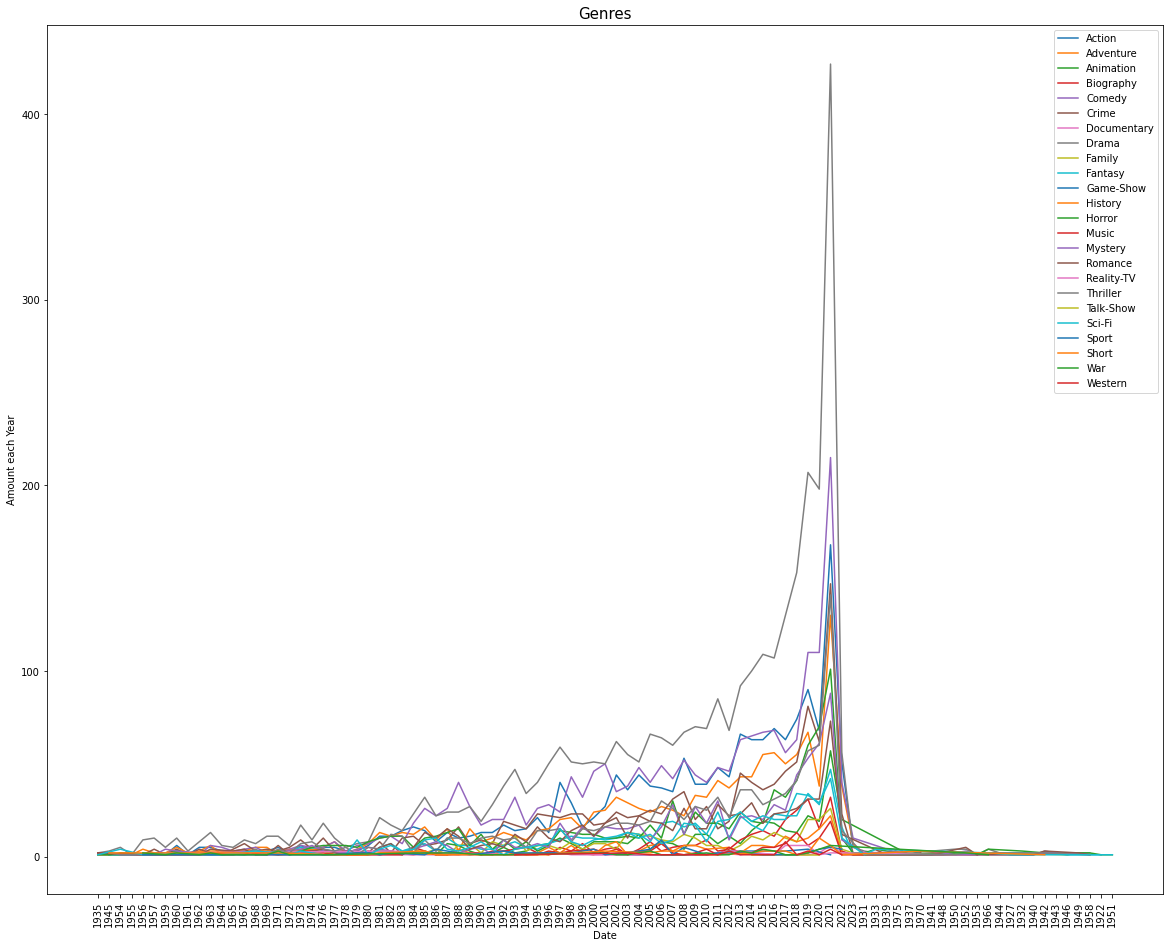

In [24]:
plt.figure(figsize=(20,16))
sns.lineplot(x=((genreGroup("Action")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Action")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Adventure")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Adventure")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Animation")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Animation")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Biography")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Biography")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Comedy")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Comedy")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Crime")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Crime")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Documentary")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Documentary")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Drama")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Drama")).groupby(['Date'])['Genre'].count()).values)


sns.lineplot(x=((genreGroup("Family")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Family")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Fantasy")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Fantasy")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Game-Show")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Game-Show")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("History")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("History")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Horror")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Horror")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Music")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Music")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Mystery")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Mystery")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Romance")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Romance")).groupby(['Date'])['Genre'].count()).values)


sns.lineplot(x=((genreGroup("Reality-TV")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Reality-TV")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Thriller")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Thriller")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Talk-Show")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Talk-Show")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Sci-Fi")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Sci-Fi")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Sport")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Sport")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("War")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("War")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Western")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Western")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Short")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Short")).groupby(['Date'])['Genre'].count()).values)



plt.title("Genres", size=15)
plt.ylabel("Amount each Year")
plt.legend(["Action", "Adventure", "Animation", "Biography", "Comedy", "Crime", "Documentary", "Drama", "Family", "Fantasy", "Game-Show", "History", "Horror", "Music", "Mystery", "Romance", "Reality-TV", "Thriller", "Talk-Show", "Sci-Fi", "Sport", "Short",  "War", "Western"])

plt.xticks(size=10, rotation=90)
plt.show()

The above graph shows the progression of every genre throught the years. 

Something that should be noted while reading the graph is that following the year 2023, the year sets back to 1931. After 1931, it shows years that were seemingly skipped over in the leftmost side of the graph. Fortunately, this seems to line up with what can already be seen on the graph.

Not many shows or films are shown to have been released in the earlier years, so this does affect the data of the early years. For years where only one film or show was released, it would obvioulsy show that genre as being the most popular of that year. 

That being said, there does not appear to be much in terms of outliers.

From the graph, we can see that the three most popular genres, Drama, Comedy, and Action, follow a trend of starting small, and then shooting up as the years go on.

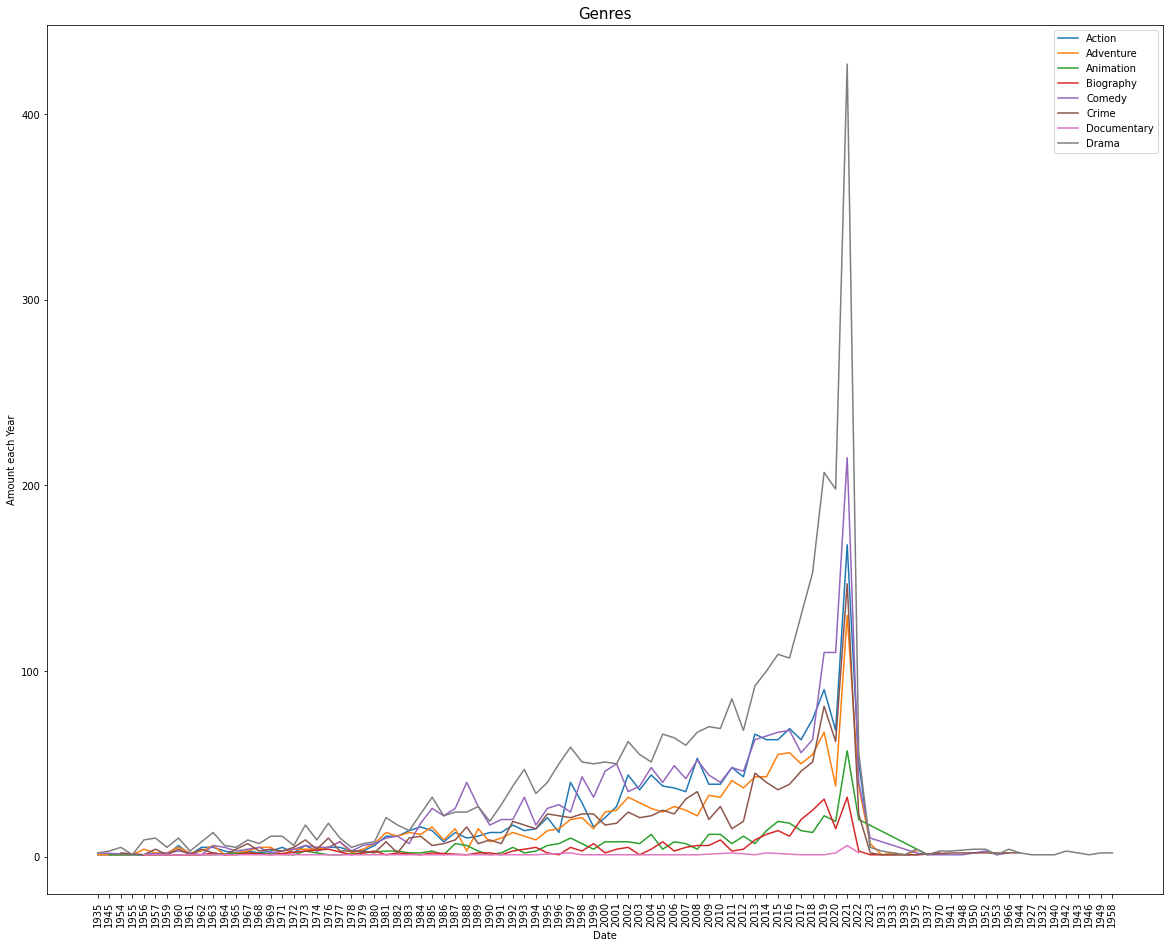

In [25]:
plt.figure(figsize=(20,16))
sns.lineplot(x=((genreGroup("Action")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Action")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Adventure")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Adventure")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Animation")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Animation")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Biography")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Biography")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Comedy")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Comedy")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Crime")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Crime")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Documentary")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Documentary")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Drama")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Drama")).groupby(['Date'])['Genre'].count()).values)





plt.title("Genres", size=15)
plt.ylabel("Amount each Year")
plt.legend(["Action", "Adventure", "Animation", "Biography", "Comedy", "Crime", "Documentary", "Drama"])

plt.xticks(size=10, rotation=90)
plt.show()

Splitting up the graph in three parts makes it easier to do an analysis of the data. 

Here, we can observe that Drama, Comedy, and Action all started small, and had instances of passing each other in popularity until 1990 where Drama became consistently the most popular. 

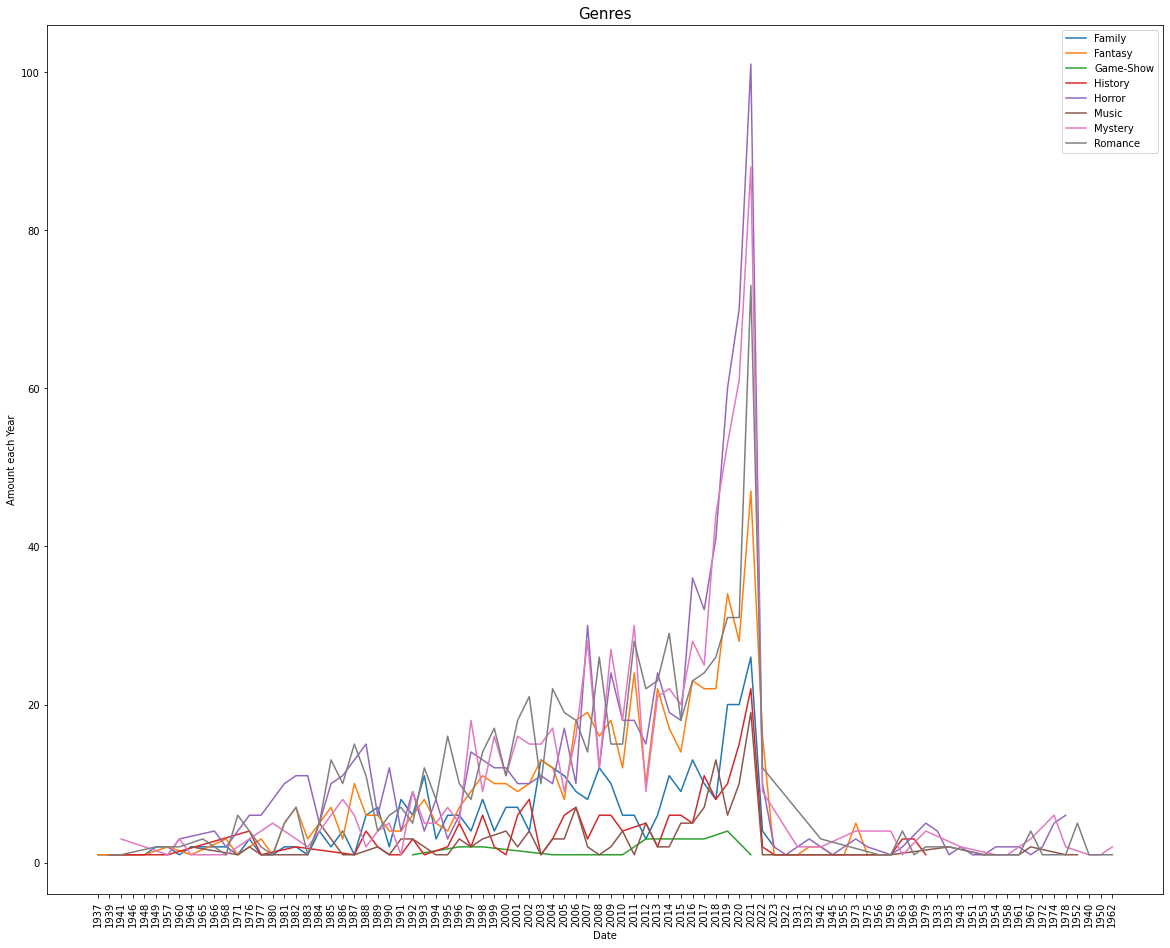

In [26]:
plt.figure(figsize=(20,16))
sns.lineplot(x=((genreGroup("Family")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Family")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Fantasy")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Fantasy")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Game-Show")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Game-Show")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("History")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("History")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Horror")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Horror")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Music")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Music")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Mystery")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Mystery")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Romance")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Romance")).groupby(['Date'])['Genre'].count()).values)



plt.title("Genres", size=15)
plt.ylabel("Amount each Year")
plt.legend(["Family", "Fantasy", "Game-Show", "History", "Horror", "Music", "Mystery", "Romance"])

plt.xticks(size=10, rotation=90)
plt.show()

Part 2 is more erratic in terms of what has been the most popular. The Horror genre appears to frequently top the other genres shown here, but we can see instances where it is over taken by Romance and Mystery. We can also see that Game Shows had a short run from 1991 to 2021. Outside of these years, seemingly no Game Show media has been released. 

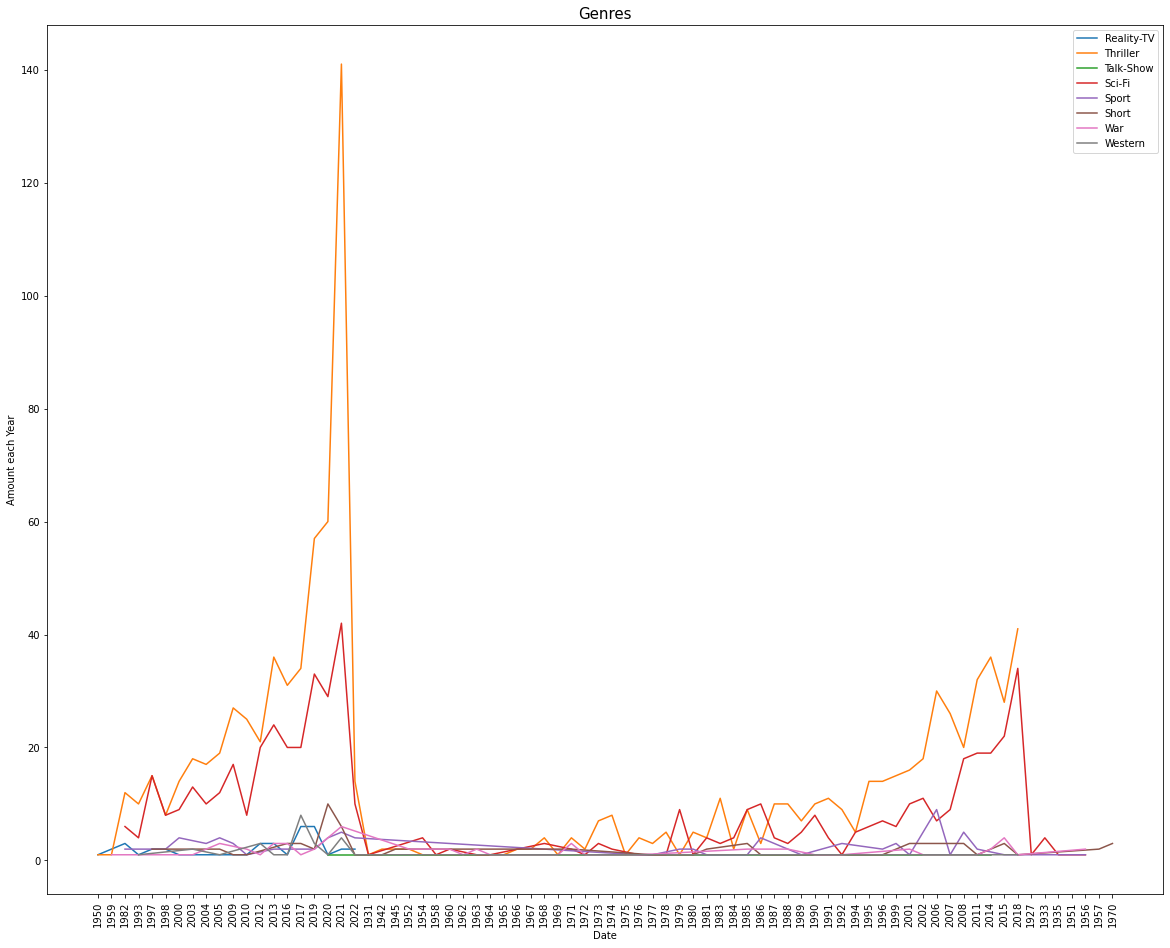

In [27]:
plt.figure(figsize=(20,16))

sns.lineplot(x=((genreGroup("Reality-TV")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Reality-TV")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Thriller")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Thriller")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Talk-Show")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Talk-Show")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Sci-Fi")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Sci-Fi")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Sport")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Sport")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("War")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("War")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Western")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Western")).groupby(['Date'])['Genre'].count()).values)
sns.lineplot(x=((genreGroup("Short")).groupby(['Date'])['Genre'].count()).index, y=((genreGroup("Short")).groupby(['Date'])['Genre'].count()).values)



plt.title("Genres", size=15)
plt.ylabel("Amount each Year")
plt.legend(["Reality-TV", "Thriller", "Talk-Show", "Sci-Fi", "Sport", "Short" ,"War", "Western"])

plt.xticks(size=10, rotation=90)
plt.show()

Finally, we can observe some of the least popular genres. Thrillers and Sci-Fi can be seen to have spikes in popularity, and do not follow any trend of becoming released more frequently over the years. 

Next, let's look at how these genres were rated, starting with the most popular, Drama, Comedy, and Action

<AxesSubplot:xlabel='Date'>

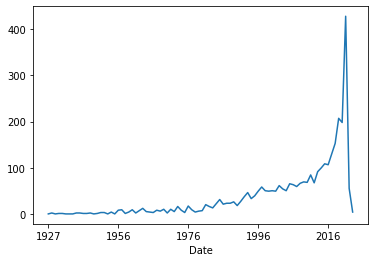

In [28]:
drama=(genreGroup("Drama"))
t1=drama.groupby('Date')['Rate'].count()
t1.plot()

<AxesSubplot:xlabel='Date'>

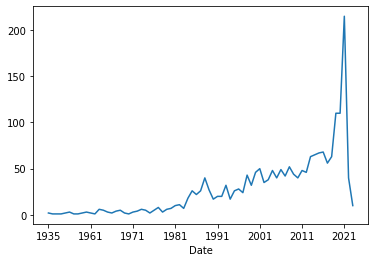

In [29]:
comedy=(genreGroup("Comedy"))
t2=comedy.groupby('Date')['Rate'].count()
t2.plot()

<AxesSubplot:xlabel='Date'>

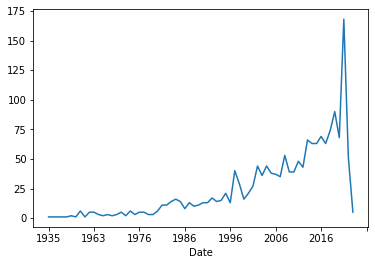

In [30]:
action=(genreGroup("Action"))
t3=action.groupby('Date')['Rate'].count()
t3.plot()

All three show a correlation with their ratings and the amount of releases. The most released genres have the highest total ratings. 

But what about the least popular? 

<AxesSubplot:xlabel='Date'>

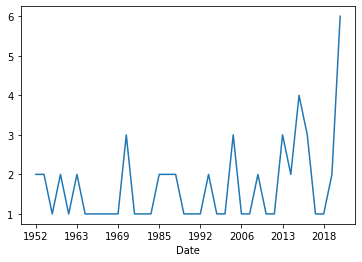

In [31]:
western=(genreGroup("Western"))
t4=western.groupby('Date')['Rate'].count()
t4.plot()

<AxesSubplot:xlabel='Date'>

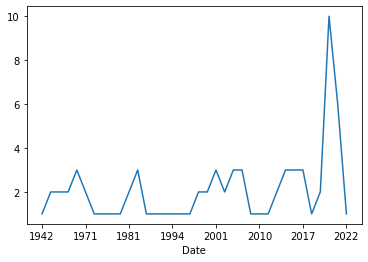

In [32]:
war=(genreGroup("War"))
t5=war.groupby('Date')['Rate'].count()
t5.plot()

Here, we can observe something notable, especially when compared next to the graph showing how often each genre was released. For instance, for Westerns in 2017, the ratings were decreasing. Looking at the amount of times a Western was published after 2017, there was a decrease. However, after a much higher total rating following 2018, we can see an increase in Westerns being made in 2019. 

We can also look at the votes to view audience engagement with the movie and see if that correlates with the popularity of the genres. 

<AxesSubplot:xlabel='Date'>

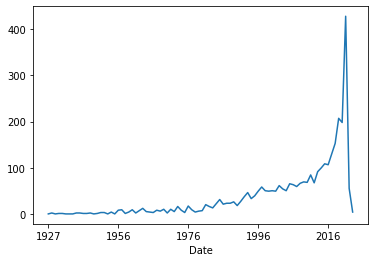

In [33]:
t1=drama.groupby('Date')['Votes'].count()
t1.plot()

<AxesSubplot:xlabel='Date'>

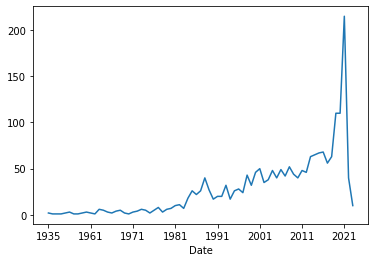

In [34]:
t2=comedy.groupby('Date')['Votes'].count()
t2.plot()

<AxesSubplot:xlabel='Date'>

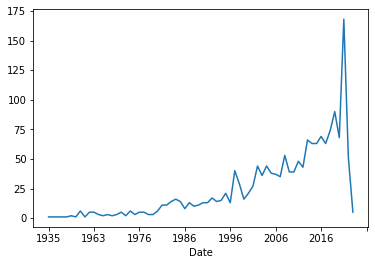

In [35]:
t3=action.groupby('Date')['Votes'].count()
t3.plot()

Here, the votes correlate with the amount of times each genre was published. Something that can be observed is that every increase and decrease of votes and ratings approximately matches the amount of publishings the following year. For comedy in 2015, there was a decrease in votes and total overall ratings. 2016 and 2017 saw less comedies being made, but after 2017 where there begins to be an increase in ratings and votes, 2018 sees more comedies being released.  

<AxesSubplot:xlabel='Date'>

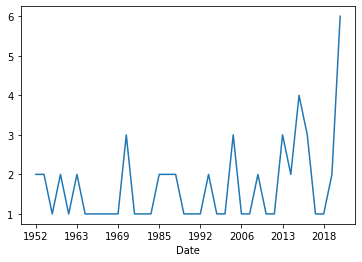

In [36]:
t4=western.groupby('Date')['Votes'].count()
t4.plot()

<AxesSubplot:xlabel='Date'>

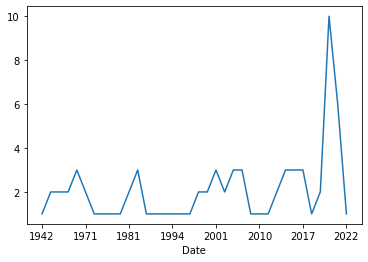

In [37]:
t5=war.groupby('Date')['Votes'].count()
t5.plot()

Here, we can see that the genre that got released the least got very few votes. The War genre had an increase in releases following 2019, but was in a decrease during 2022, where it got almost no votes at all. It started to get more votes a little before 1981, and we can see that War movies were starting to release again in 1985 briefly, but we can see that following its' increase to a little after 1981, the votes dropped again, as did the releases of the War genre. 

In conclusion, it does appear that ratings correlate with the popularity of each genre. 
It also seems that both votes and ratings have an influence in what genres get released every year. 

#### What impact does mature content make on the ratings of movies/shows the most?

This question requires six different columns from the dataframe: 'Rate', 'Nudity', 'Violence', 'Profanity', 'Alcohol', and 'Frightening'. Of course, every column other than 'Rate' represents some sort of mature content. The entries in the mature content columns can be None, No Rate, Mild, Moderate, or Severe. Since a movie can have one more of these sorts of mature content, using a scale to help identify how much mature content is in one movie/show compared to another.

The scale will be represented as such:

In [45]:
scale_data = {'Mature Content': ['None', 'No Rate', 'Mild', 'Moderate', 'Severe'], 'Value on Scale': [0, 0, 1, 2, 3]}
scale_df = pd.DataFrame(scale_data)
scale_df

,Mature Content,Value on Scale
0,None,0
1,No Rate,0
2,Mild,1
3,Moderate,2
4,Severe,3


Note: This scale has been created for visual purposes only and is not part of the analysis code. 

Before beginning the process of plotting the 'Mature Content' and 'Rate' data, some data cleaning needs to be performed. Firstly, any duplicates in the dataframe were removed earlier. Furthermore, it was hard to tell initially if there were any entries that had 'No Rate' as their rate since they weren't near the top or bottom sections of the data. However, a further look at the original source of the data from Kaggle showed that there were indeed certain entries that were not wanted. As a result, the rows (entries) containing 'No Rate' in the 'Rate' Column were removed. Another change that needed to be made before plotting was converting the entries in the 'Rate' column to floats as they were Strings originally.

<AxesSubplot:title={'center':'Rating vs. Amount of Mature Content'}, xlabel='Rate', ylabel='Mature Content Sum'>

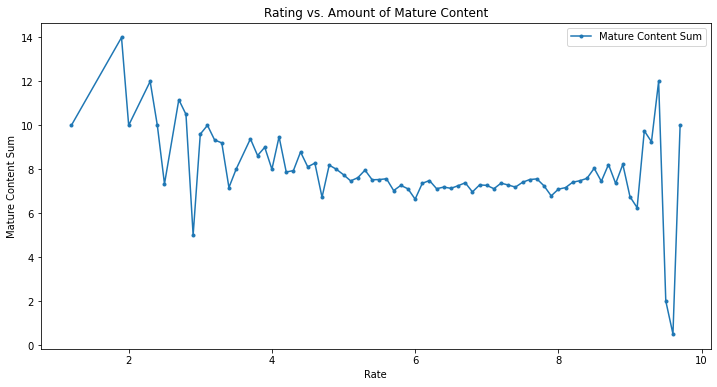

In [47]:
dfTemp = df[(df.Rate != 'No Rate')]     # Remove rows with any 'No Rate' entries in the 'Rate' column
dfTemp['Rate'] = dfTemp['Rate'].apply(lambda x: float(x))     # Remove rows with any 'No Rate' entries in the 'Rate' column  

def mature_count(x):
    count = 0;
    for i in x['Nudity']:            # function for calculating sum of mature content
        if (i == 'i'):
            count = count + 1
        elif (i == 't'):
            count = count + 2
        elif (i == 'S'):
            count = count + 3
    for i in x['Violence']:          # Mild, Moderate, and Severe levels of mature content are whwt need to be considered
        if (i == 'i'):               # so take unique letters in each word that aren't in the other words (i in Mild,
            count = count + 1        # t in Moderate, S in Severe) to keep track of levels of maturity in each entry
        elif (i == 't'):
            count = count + 2
        elif (i == 'S'):
            count = count + 3
    for i in x['Profanity']:
        if (i == 'i'):
            count = count + 1
        elif (i == 't'):
            count = count + 2
        elif (i == 'S'):
            count = count + 3
    for i in x['Alcohol']:
        if (i == 'i'):
            count = count + 1
        elif (i == 't'):
            count = count + 2
        elif (i == 'S'):
            count = count + 3       
    for i in x['Frightening']:
        if (i == 'i'):
            count = count + 1
        elif (i == 't'):
            count = count + 2
        elif (i == 'S'):
            count = count + 3
    return count

dfTemp['Mature Content Sum'] = df.apply(lambda x: mature_count(x), axis = 1)   
mature_content_df = dfTemp[['Mature Content Sum', 'Rate']]
mature_content_df.groupby(['Rate']).mean().plot.line(title = 'Rating vs. Amount of Mature Content', ylabel = 'Mature Content Sum', figsize = (12,6), style = '.-')

As we can see, there are certain points in the graph that stick out, with the most notable one being near the right-most part of the graph. Although there are clearly other points in the graph that are much higher or lower than others, none are more apart than the two just mentioned. As a result, we can remove these two points on the graph to have a better view of the others. These two points are not outliers, but rather a combination of two values that were uncommon. 

<AxesSubplot:title={'center':'Rating vs. Amount of Mature Content'}, xlabel='Rate', ylabel='Mature Content Sum'>

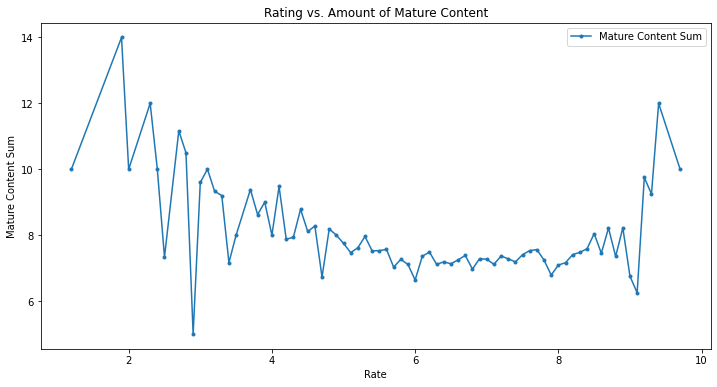

In [48]:
mature_content_df.sort_values(by = 'Rate')     # points being removed are near the right-most part of the graph so sorting would help us track them
mature_content_df.drop(index = [2780, 1754, 909], inplace = True)
mature_content_df.groupby(['Rate']).mean().plot.line(title = 'Rating vs. Amount of Mature Content', ylabel = 'Mature Content Sum', figsize = (12,6), style = '.-')

Note: Three points were removed instead of two since two of those three points were very close to one another.

After removing the aforementioned points, we can now try to identify trends in the data. The points in the graph steadily move downwards starting from the left side of this graph with many large dips being visible. The points than roughly starighten up near the middle before steadily moving upwards with a few large increases near the end. To verify these observations, we will find the slopes of these three sections of the graph by approximately dividing the total number of x values (rates) by 3. 

In [49]:
left_slope_interval = mature_content_df.sort_values(by = 'Rate').values[: len(mature_content_df) // 3].tolist()     
left_slope_values = left_slope_interval[0], left_slope_interval[-1]
left_slope = (left_slope_values[1][1] - left_slope_values[0][1]) / (left_slope_values[1][0] - left_slope_values[0][0])  #Using equation of slope between two points

middle_slope_interval = mature_content_df.sort_values(by = 'Rate').values[len(mature_content_df) // 3 : int(len(mature_content_df) / 1.5)].tolist()
middle_slope_values = middle_slope_interval[0], middle_slope_interval[-1]
middle_slope = (middle_slope_values[1][1] - middle_slope_values[0][1]) / (middle_slope_values[1][0] - middle_slope_values[0][0])

right_slope_interval = mature_content_df.sort_values(by = 'Rate').values[int(len(mature_content_df) / 1.5) : len(mature_content_df) - 1].tolist()
right_slope_values = right_slope_interval[0], right_slope_interval[-1]
right_slope = (right_slope_values[1][1] - right_slope_values[0][1]) / (right_slope_values[1][0] - right_slope_values[0][0])

print('Left slope:', left_slope)
print('Middle slope:', middle_slope)
print('Right slope:', right_slope)

Left slope: -1.325
Middle slope: -0.12857142857142861
Right slope: 1.0


The calculation for each of the slopes matches our observations from the graph. Both our graphs and calculations have now shown that this data takes on a shape similar to a parabola.  

In the context of our data, a parabolic-like shape means that as our rating increases, the amount of mature content either can increase, decrease, or just approximately stay the same. In response to the original research question, this essentially means that the amount of mature content does not have much of an impact on the rating of a movie or show. 

#### Do TV series or movies perform better? Based on the year of publish, does this make an impact or change the ratings?

In [38]:
#removing empty ratings
dfRates = df.loc[df['Rate']!= 'No Rate']
#converting ratings to float and dates to int so that operations can be performed on them
dfRates['Rate'] = dfRates['Rate'].astype(float)
dfRates['Date'] = dfRates['Date'].astype(int)
#gets total number of movies and tv shows
dfRates['Type'].value_counts()

Film      4301
Series    1692
Name: Type, dtype: int64

First we'll start by looking at the total number of films released vs the number of TV series. Looking at this, there are over twice as many films as series. We'll follow this by looking at the average ratings of both films and TV series.

<AxesSubplot:title={'center':'Average Film Ratings vs Series Ratings'}, xlabel='Type', ylabel='Average rating'>

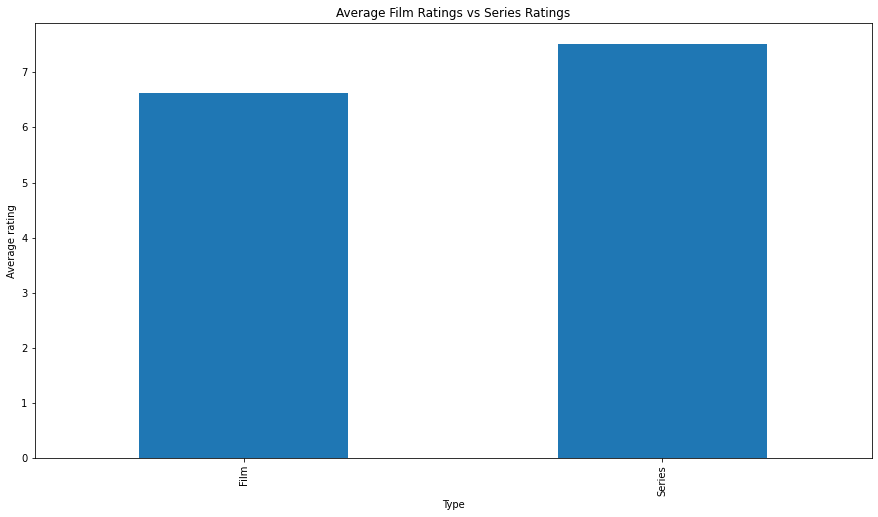

In [39]:
df_pivot = pd.pivot_table(data=dfRates, values='Rate', index=['Type'], aggfunc='mean')
df_pivot.plot(kind='bar', figsize = (15,8), title='Average Film Ratings vs Series Ratings', ylabel='Average rating', legend = {})

Here we can see the average rating for series is slightly higher than films, despite the total number of films being higher. Next let's look at how these ratings change over time.

In [40]:
dfRates = dfRates.sort_values(by=['Date'], ascending=True)
dfRates

,Name,Date,Rate,Votes,Genre,Duration,Type,Certificate,Episodes,Nudity,Violence,Profanity,Alcohol,Frightening
3107,Nosferatu,1922,7.9,"92,629","Fantasy, Horror",94,Film,Not Rated,-,None,Mild,None,Mild,Moderate
2945,Metropolis,1927,8.3,"167,247","Drama, Sci-Fi",153,Film,Not Rated,-,Mild,Mild,None,Mild,Moderate
3594,M - Eine Stadt sucht einen Mörder,1931,8.3,"151,051","Crime, Mystery, Thriller",117,Film,Passed,-,None,Mild,Mild,Mild,Moderate
2221,The Wilds,1931,7.3,"13,430","Adventure, Drama, Mystery",None,Series,TV-14,17,Moderate,Mild,Severe,Mild,Mild
2220,Frankenstein,1931,7.8,"68,780","Drama, Horror, Sci-Fi",70,Film,Passed,-,None,Mild,None,Mild,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5575,Tales of the Unexpected,2022,7.7,"1,873","Comedy, Drama, Horror",25,Series,None,112,No Rate,No Rate,No Rate,No Rate,No Rate
4404,Jonathan Creek,2023,8.1,"7,069","Comedy, Crime, Drama",60,Series,TV-MA,32,Moderate,Moderate,Moderate,No Rate,Mild
5554,Jonathan Creek,2023,8.1,"7,069","Comedy, Crime, Drama",60,Series,TV-MA,32,Moderate,Moderate,Moderate,No Rate,Mild
5872,One Foot in the Grave,2023,7.8,"6,070","Comedy, Drama",90,Series,TV-PG,44,None,Mild,Moderate,Mild,Mild


Looking at the head and tail, we can see that the data set includes films and series from 1922 to 2023. It doesn't make sense to include the ratings of films and series that haven't been released yet, so we'll filter out all the rows from after 2021 and only looking at the ones from 1922 to 2021. Also, we'll be using line graphs to look at the change of average ratings over time.

<AxesSubplot:title={'center':'Average Film vs Series Ratings per Year'}, xlabel='Date', ylabel='Average Rating'>

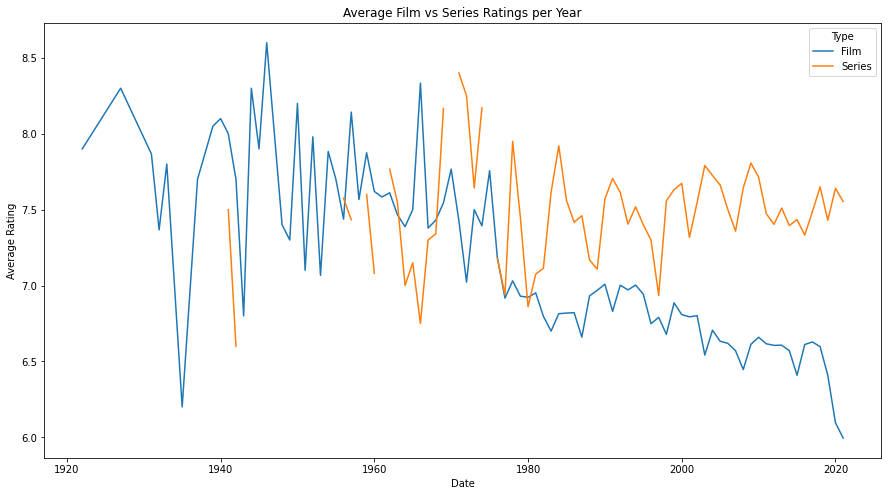

In [41]:
#remove ratings after 2021
dfRates = dfRates.loc[dfRates['Date']<= 2021]
#get pivot table of reviews over time
df_pivot = pd.pivot_table(data=dfRates, values='Rate', index=['Date'], columns=['Type'], aggfunc='mean')
#Generate plot
df_pivot.plot(kind='line', figsize = (15,8), title='Average Film vs Series Ratings per Year', ylabel='Average Rating')

Looking at the average ratings per year, films started either higher than or around where series are, however around the 70s to 80s they began falling off in ratings. As the ratings of films decreased, the ratings of series stayed about the same.

<AxesSubplot:title={'center':'Average Film vs Series Maximum Rating per Year'}, xlabel='Date', ylabel='Maximum Rating'>

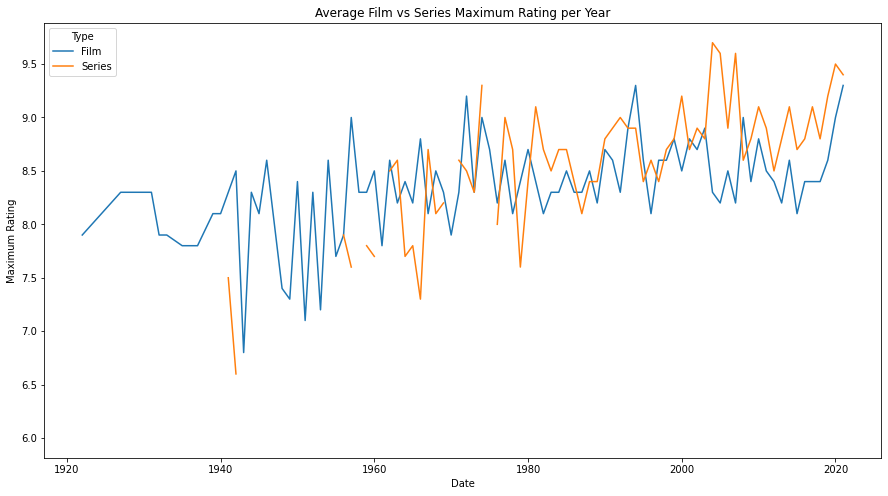

In [42]:
#gets pivot table of best reviews per year
df_pivot = pd.pivot_table(data=dfRates, values='Rate', index=['Date'], columns=['Type'], aggfunc='max')
#Generate plot
df_pivot.plot(kind='line', figsize = (15,8), title='Average Film vs Series Maximum Rating per Year', ylabel='Maximum Rating')

<AxesSubplot:title={'center':'Average Film vs Series Minimum Rating per Year'}, xlabel='Date', ylabel='Minimum Rating'>

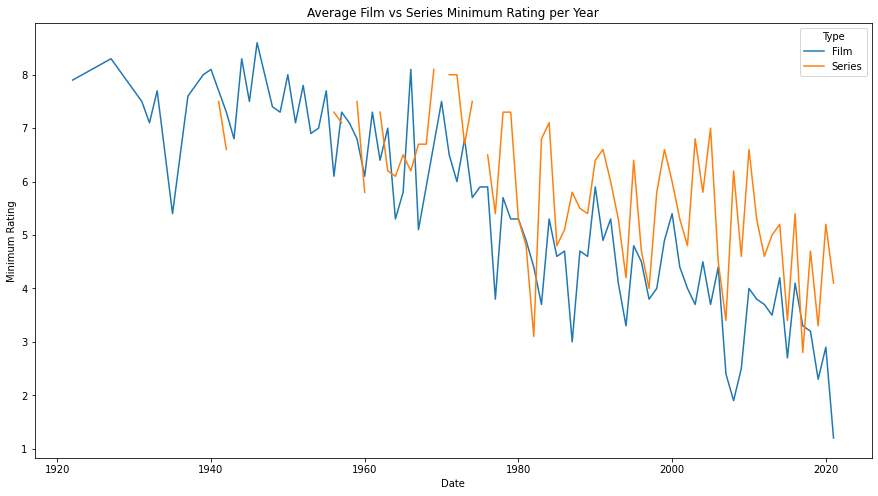

In [43]:
#gets pivot table of worst reviews per year
df_pivot = pd.pivot_table(data=dfRates, values='Rate', index=['Date'], columns=['Type'], aggfunc='min')
#Generate plot
df_pivot.plot(kind='line', figsize = (15,8), title='Average Film vs Series Minimum Rating per Year', ylabel='Minimum Rating')

Looking at the maximum and minimum of the ratings per year, series and films have very similar maxes, however around the 80s, the minimums begin to seperate. The films' minimum is consistently lower than the series minimum after the 80s-90s. Let's look at the number of series and films produced to get a better idea of what happened in this time. The difference between the maximum and minimum ratings increases each year as well.

<AxesSubplot:title={'center':'Total Films vs Series per Year'}, xlabel='Date', ylabel='Maximum Rating'>

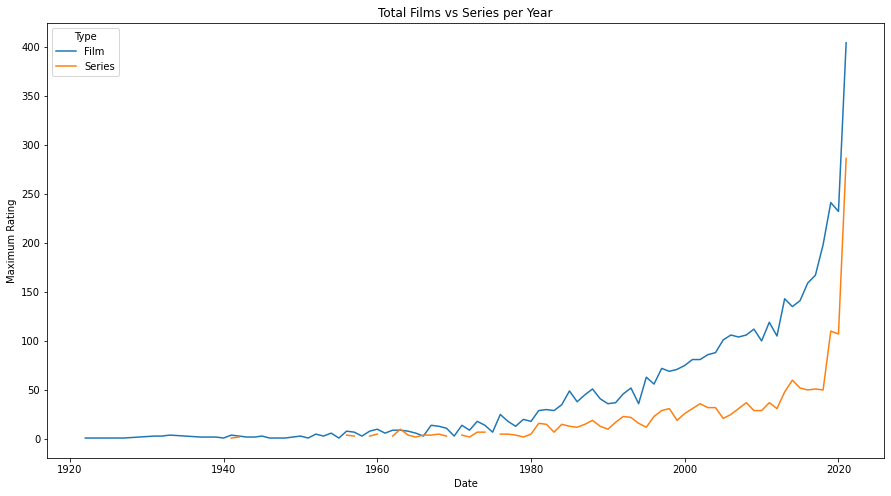

In [44]:
#gets pivot table of total films and series per year
df_pivot = pd.pivot_table(data=dfRates, values='Rate', index=['Date'], columns=['Type'], aggfunc='count')
#Generate plot
df_pivot.plot(kind='line', figsize = (15,8), title='Total Films vs Series per Year', ylabel='Maximum Rating')

Looking at the number of films vs TV series produced over time shows that there is a noticeable increase in films produced after the 70s to 80s. This aligns with the rest of the data shown, as this was around the time that film ratings started dropping below TV series ratings. This means one likely explanation of the discrepancy between film ratings and series ratings is that there is simply a larger sample size for films than series. This could bring down the average rating due to there being a larger number of more middling performing movies than series. Another interesting thing to note is that TV series were not being produced consistently until the 60s to 70s. It's also possible that the more frequent production of series was what caused a decline in film ratings. This seems less likely than a sampling size difference however.

#### Roadblocks, errors, and what could have been done better
* It was discovered late into analysis that there was over 1000 duplicate entries in the dataset.
* The dataset has collectively skewed ratings since the average of the entire run of a series is placed in a single rating. There is no way to determine trends of how a series did year upon year.
* It could have been a good idea to find parse the data further based on rate vs votes. Some series could have the potential to be skewed by vote brigading.
* Subdividing episode counts into multiple sections may have also been a good idea instead of straight truncation.
* There were complications in separating each of the combined genres from each other. Originally, each genre was going to get its' own dataframe, but this would have taken a longer time. Another early approach was to separate every combination into new rows, but this method proved to be unsuccessful and time consuming.
* the function used for gathering the levels of mature content (mild, moderate, etc.) for each entry was coded a bit differently. Characters were combined together to form a string and then were matched with the levels of mature content, however, this resulted in different values for the amount of mature content. To avoid spending too much time on the function, the code was changed to what it is now since this version of the function produces the right values.
* We found that curiously, some titles for series and films are post dated in the future. While this makes sense for unreleased films, this is also present for some tv series that have ended or have stopped airing for years. We have concluded that this is an error in the dataset itself, and not of our own procedures

    
    

## Potential Data Science

A potential data science or machine learning project would be to perhaps try and predict the ratings of a movie given the mature content, genre, year of release, and number of episodes if it's a series. This data could also be used to try and generate a combination of these to determine what the highest rating potential movie/series would be. If this were accurate, it could be used by production companies to determine what their next film or series should be.

## Conclusion